# Forecasting Taxi Trips

In this notebook, I use a LSTM model to try forecast taxi trips at an hourly level. It currently is a Keras implementation but will convert to pyTorch shortly.

The only feature to be used is the previous window history of trips, the size of the window depends on the look-back function.

In [334]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns

In [ ]:
path = r'../data/raw'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [36]:
frame.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-06-01 00:15:40,2018-06-01 00:16:46,1,0.0,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30
1,1,2018-06-01 00:04:18,2018-06-01 00:09:18,1,1.0,1,N,230,161,1,5.5,0.5,0.5,1.35,0.0,0.3,8.15
2,1,2018-06-01 00:14:39,2018-06-01 00:29:46,1,3.3,1,N,100,263,2,13.0,0.5,0.5,0.00,0.0,0.3,14.30
3,1,2018-06-01 00:51:25,2018-06-01 00:51:29,3,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
4,1,2018-06-01 00:55:06,2018-06-01 00:55:10,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80


In [37]:
frame['tpep_pickup_datetime'].min()

'2001-01-01 00:01:48'

In [86]:
dates = frame[['tpep_pickup_datetime', 'payment_type']]

In [87]:
dates['tpep_pickup_datetime'] = pd.to_datetime(dates['tpep_pickup_datetime'])
dates = dates.set_index('tpep_pickup_datetime') 
grouped = dates.resample('1h').count()

/Users/james.malcolm/anaconda3/envs/taxis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [93]:
grouped = grouped['2018-01-01':'2018-06-30']
grouped.head()

,payment_type
tpep_pickup_datetime,
2018-01-01 00:00:00,16458
2018-01-01 01:00:00,18985
2018-01-01 02:00:00,16561
2018-01-01 03:00:00,12611
2018-01-01 04:00:00,8726


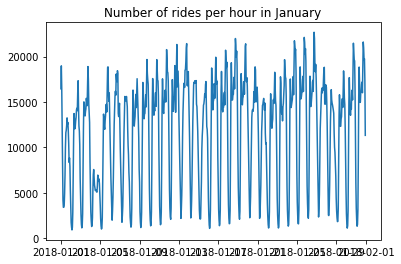

In [102]:
plt.plot(grouped['2018-01'])
plt.title("Number of rides per hour in January");

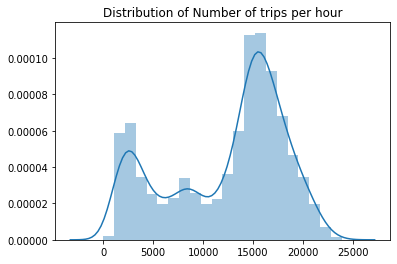

In [337]:
sns.distplot(grouped)
plt.title("Distribution of Number of trips per hour");

### Feature Scaling

As with most Deep Learning approaches, scaling the features is reccomended and we do this here for the number of trips. By default, this will bound them between 0 and 1.

In [288]:
from sklearn.preprocessing import MinMaxScaler

In [289]:
scaler = MinMaxScaler()

scaled = scaler.fit_transform(grouped)

In [290]:
train_size = int(len(scaled) * 0.80)
train, test = scaled[0:train_size], scaled[train_size:]
assert len(train) + len(test) == len(scaled)

In [291]:
def lookback(dataset, n_periods=1):
    X, Y = [], []
    for i in range(len(dataset) - n_periods - 1):
        a = dataset[i:(i + n_periods), 0]
        X.append(a)
        Y.append(dataset[i + n_periods, 0])
    return np.array(X), np.array(Y)

In [321]:
n_periods = 72

In [322]:
X_train, Y_train = lookback(train, n_periods)
X_test, Y_test = lookback(test, n_periods)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [323]:
X_train.shape

(3402, 1, 72)

In [227]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
Y_train = torch.from_numpy(Y_train).type(torch.Tensor)
Y_test = torch.from_numpy(Y_test).type(torch.Tensor)

X_train = X_train.view([24, -1, 1])
X_test = X_test.view([24, -1, 1])

In [228]:
import torch
import torch.nn as nn

In [244]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, batch_size, num_layers, output_dim=1):
        super(LSTM, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, output_dim)
    
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def forward(self, x):
        hidden = self.init_hidden()
        lstm_out, hidden = self.lstm(x, hidden)
        
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

In [245]:
model = LSTM(24, 34, 3450, 2, 1)
loss_func = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())
num_epochs = 10

In [246]:
epoch_loss = []

for epoch in range(num_epochs):
    optim.zero_grad()
    
    y_pred = model(X_train)
    loss = loss_func(y_pred, y_train)
    optim.step()

    print("Epoch ", t, "MSE: ", loss.item())
    tracking_loss.append(loss.item())

RuntimeError: input.size(-1) must be equal to input_size. Expected 24, got 1

In [325]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM

from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [338]:
model = Sequential()
model.add(LSTM(34, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=30, batch_size=70, validation_data=(X_test, Y_test), shuffle=False)

model.summary()

Train on 3402 samples, validate on 796 samples
Epoch 1/30
3402/3402 [==============================] - 1s 223us/step - loss: 0.0700 - val_loss: 0.0208
Epoch 2/30
3402/3402 [==============================] - 0s 30us/step - loss: 0.0192 - val_loss: 0.0126
Epoch 3/30
3402/3402 [==============================] - 0s 29us/step - loss: 0.0150 - val_loss: 0.0104
Epoch 4/30
3402/3402 [==============================] - 0s 27us/step - loss: 0.0128 - val_loss: 0.0087
Epoch 5/30
3402/3402 [==============================] - 0s 28us/step - loss: 0.0108 - val_loss: 0.0072
Epoch 6/30
3402/3402 [==============================] - 0s 28us/step - loss: 0.0089 - val_loss: 0.0058
Epoch 7/30
3402/3402 [==============================] - 0s 28us/step - loss: 0.0074 - val_loss: 0.0051
Epoch 8/30
3402/3402 [==============================] - 0s 27us/step - loss: 0.0063 - val_loss: 0.0044
Epoch 9/30
3402/3402 [==============================] - 0s 28us/step - loss: 0.0055 - val_loss: 0.0038
Epoch 10/30
3402/3402 [==

In [339]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([Y_test])

In [340]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [341]:
mean_absolute_error(train_predict, y_train[0])

794.2287440403709

In [342]:
mean_squared_error(train_predict, y_train[0])

1166293.031458517

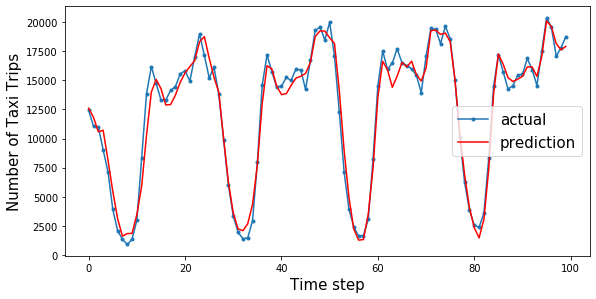

In [343]:
plt.figure(figsize=(8,4))
plt.plot(y_test[0][:100], marker='.', label="actual")
plt.plot(test_predict[:,0][:100], 'r', label="prediction")

plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Number of Taxi Trips', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();